# Convolutional Neural Network using Pytorch for Facial Emotion Detection

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


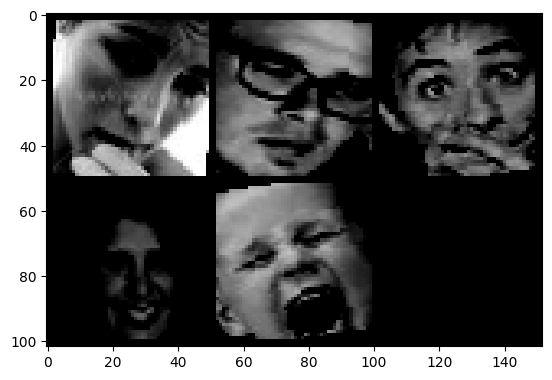

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import cv2

# Data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


train_dataset = ImageFolder('facial_data/train', transform=transform)
test_dataset = ImageFolder('facial_data/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:5], nrow=3))


In [12]:
# Defining the convolutional neural network model

class EmotionModel(nn.Module):
    def __init__(self):
        super(EmotionModel,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, input):
        out = self.stn(input)

        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out


model = EmotionModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


In [2]:

train_losses = []
test_losses = []
num_epochs = 100
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss / len(test_loader))  
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')


/opt/homebrew/anaconda3/envs/soft/lib/python3.11/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/homebrew/anaconda3/envs/soft/lib/python3.11/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch 1/100: Train Loss: 1.7939, Train Accuracy: 25.88%, Test Loss: 1.7539, Test Accuracy: 28.17%
Epoch 2/100: Train Loss: 1.7213, Train Accuracy: 30.47%, Test Loss: 1.7000, Test Accuracy: 32.10%
Epoch 3/100: Train Loss: 1.6791, Train Accuracy: 32.97%, Test Loss: 1.6649, Test Accuracy: 34.31%
Epoch 4/100: Train Loss: 1.6526, Train Accuracy: 34.49%, Test Loss: 1.6464, Test Accuracy: 34.84%
Epoch 5/100: Train Loss: 1.6283, Train Accuracy: 36.01%, Test Loss: 1.6123, Test Accuracy: 37.22%
Epoch 6/100: Train Loss: 1.6108, Train Accuracy: 36.84%, Test Loss: 1.6046, Test Accuracy: 37.59%
Epoch 7/100: Train Loss: 1.5891, Train Accuracy: 37.96%, Test Loss: 1.5752, Test Accuracy: 38.70%
Epoch 8/100: Train Loss: 1.5722, Train Accuracy: 38.94%, Test Loss: 1.5550, Test Accuracy: 38.85%
Epoch 9/100: Train Loss: 1.5510, Train Accuracy: 39.95%, Test Loss: 1.5408, Test Accuracy: 40.44%
Epoch 10/100: Train Loss: 1.5358, Train Accuracy: 40.32%, Test Loss: 1.5169, Test Accuracy: 41.17%
Epoch 11/100: Train

Epoch 84/100: Train Loss: 1.2200, Train Accuracy: 53.42%, Test Loss: 1.2561, Test Accuracy: 52.27%
Epoch 85/100: Train Loss: 1.2149, Train Accuracy: 53.05%, Test Loss: 1.2609, Test Accuracy: 51.25%
Epoch 86/100: Train Loss: 1.2137, Train Accuracy: 53.58%, Test Loss: 1.2613, Test Accuracy: 51.67%
Epoch 87/100: Train Loss: 1.2164, Train Accuracy: 53.19%, Test Loss: 1.2444, Test Accuracy: 52.37%
Epoch 88/100: Train Loss: 1.2117, Train Accuracy: 53.56%, Test Loss: 1.2577, Test Accuracy: 51.50%
Epoch 89/100: Train Loss: 1.2123, Train Accuracy: 53.50%, Test Loss: 1.2664, Test Accuracy: 51.67%
Epoch 90/100: Train Loss: 1.2058, Train Accuracy: 53.86%, Test Loss: 1.2537, Test Accuracy: 51.84%
Epoch 91/100: Train Loss: 1.2062, Train Accuracy: 53.79%, Test Loss: 1.2381, Test Accuracy: 52.69%
Epoch 92/100: Train Loss: 1.2096, Train Accuracy: 53.64%, Test Loss: 1.2500, Test Accuracy: 52.20%
Epoch 93/100: Train Loss: 1.2056, Train Accuracy: 53.82%, Test Loss: 1.2494, Test Accuracy: 52.45%
Epoch 94/1

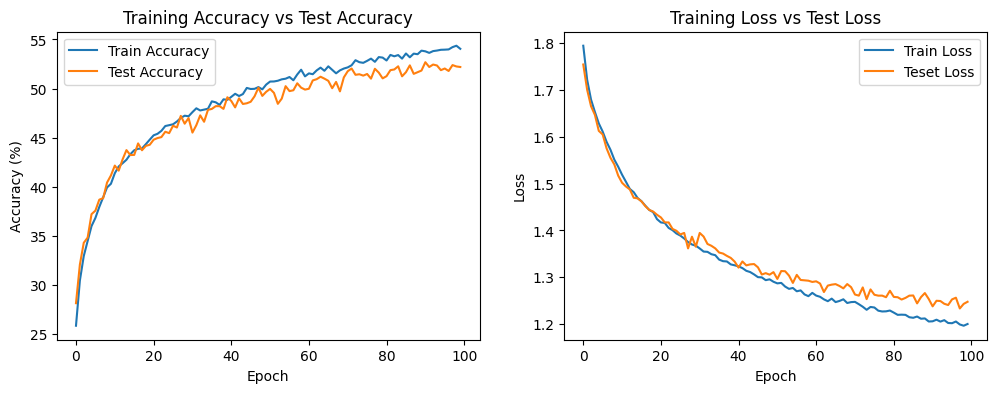

In [3]:

# Plotting training and Testing accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training Accuracy vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Teset Loss')
plt.title('Training Loss vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [4]:
# Saving the model structure in a pth file
model_structure = model.to(torch.device('cpu'))
torch.save(model_structure, 'model/emotion_model.pth')

# Saving trained model weights in a file (PyTorch's format)
torch.save(model.state_dict(), 'model/emotion_model_weights.pth')

/opt/homebrew/anaconda3/envs/soft/lib/python3.11/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/homebrew/anaconda3/envs/soft/lib/python3.11/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Accuracy: 0.520479


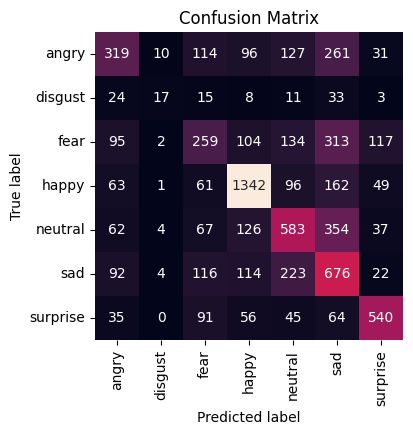

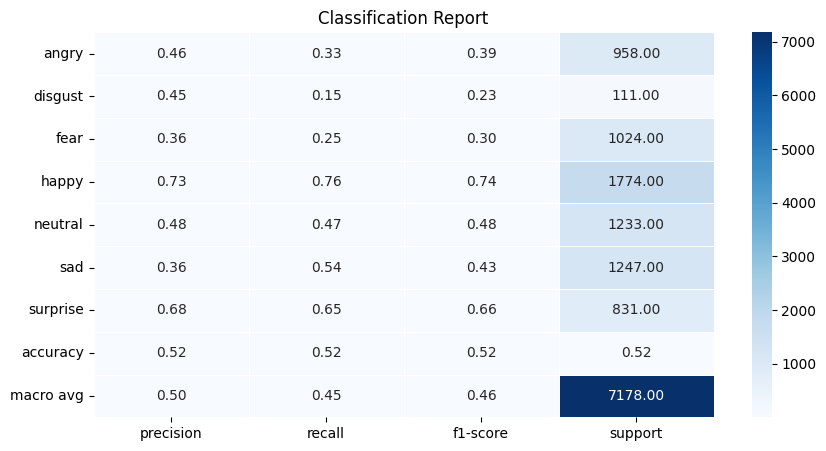

In [9]:
# Loading  pre-trained model
model_path = 'model/emotion_model_weights.pth'
model = EmotionModel()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

y_true = np.array([labels for _, labels in test_dataset])
y_pred = []

with torch.no_grad():
    for data, _ in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())

# confusion matrix, accuracy, and classification report
cm_test = confusion_matrix(y_true, y_pred)
train_accuracy = accuracy_score(y_true, y_pred)
print(f'Train Accuracy: {train_accuracy:.6f}')

labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, square=True, annot=True, fmt='d', cbar=False,
            xticklabels= labels,
            yticklabels= labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 5))
sns.heatmap(df.iloc[:-1, :4], annot=True, cmap='Blues', fmt='.2f', linewidths=.5)
plt.title('Classification Report')
plt.show()


Predicting emotion for samples/happy_test2.png:


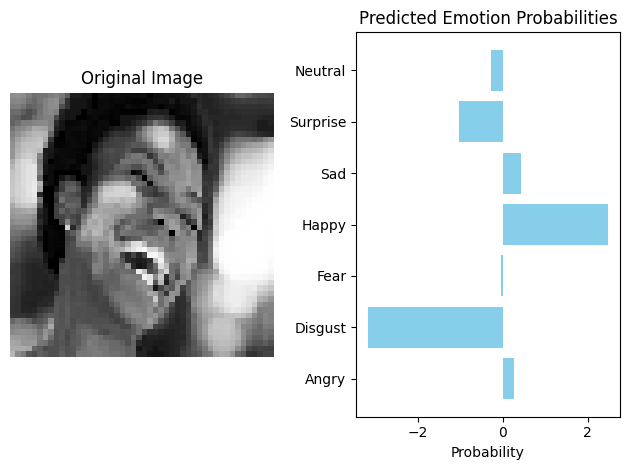

Predicted Emotion: Happy
Predicting emotion for samples/sad_test.jpeg:


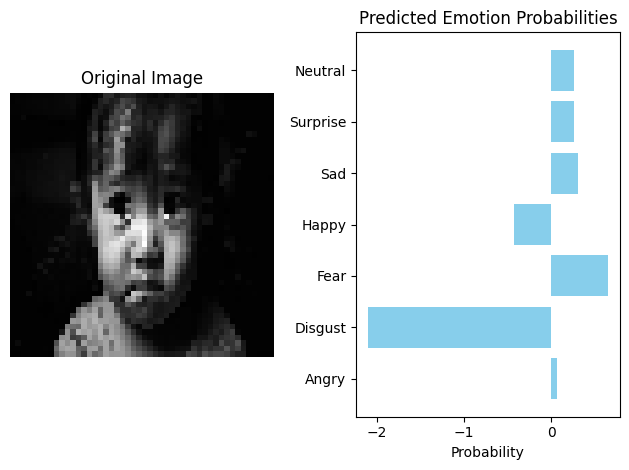

Predicted Emotion: Fear
Predicting emotion for samples/fear_test.jpeg:


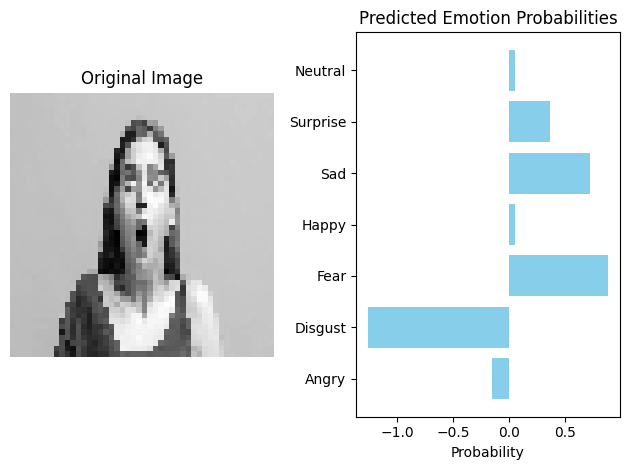

Predicted Emotion: Fear
Predicting emotion for samples/surprise_test.jpeg:


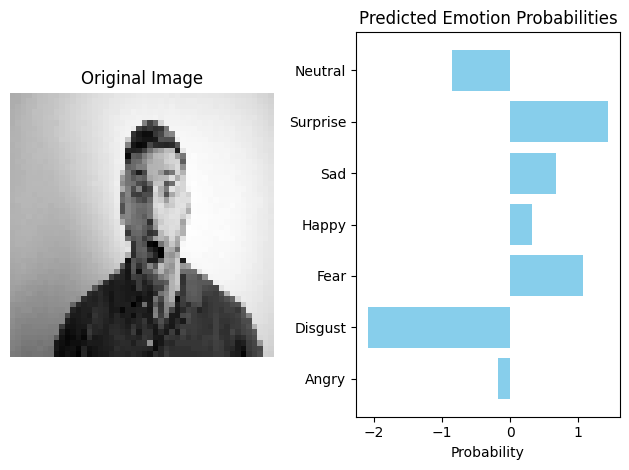

Predicted Emotion: Surprise
Predicting emotion for samples/angry.png:


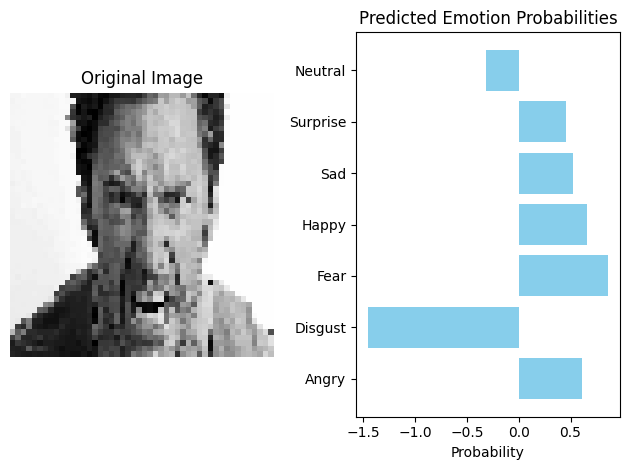

Predicted Emotion: Fear


In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

# Loading  pre-trained model
model_path = 'model/emotion_model_weights.pth'
model = EmotionModel()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

def predict_emotion(image_path):
    new_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    new_image = cv2.resize(new_image, (48, 48))
    new_image = new_image / 255.0
    new_image = np.expand_dims(new_image, axis=0)  # Add a batch dimension
#     new_image_tensor = torch.Tensor(new_image)
    new_image_tensor = torch.Tensor(new_image).unsqueeze(0)

    with torch.no_grad():
        predictions = model(new_image_tensor)

    predicted_class = torch.argmax(predictions, dim=1).item()

    class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    plt.subplot(1, 2, 1)
    plt.imshow(new_image[0], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.barh(class_labels, predictions[0].numpy(), color='skyblue')
    plt.xlabel( 'Probability')
    plt.title('Predicted Emotion Probabilities')

    plt.tight_layout()
    plt.show()

    print(f'Predicted Emotion: {class_labels[predicted_class]}')

image_paths = [
    'samples/happy_test2.png',
    'samples/sad_test.jpeg',
    'samples/fear_test.jpeg',
    'samples/surprise_test.jpeg',
    'samples/angry.png'
]

for image_path in image_paths:
    print(f'Predicting emotion for {image_path}:')
    predict_emotion(image_path)


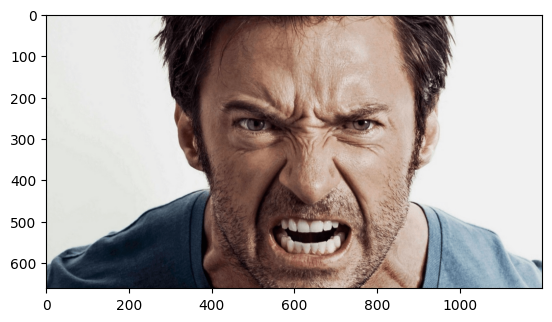

Action: emotion: 100%|████████████████████████████| 1/1 [00:00<00:00,  8.46it/s]

[{'emotion': {'angry': 75.72526931762695, 'disgust': 2.2946879951746268e-07, 'fear': 24.27472472190857, 'happy': 2.881488518386051e-12, 'sad': 1.0307255138286564e-05, 'surprise': 4.856483054246907e-11, 'neutral': 5.544447821866083e-11}, 'dominant_emotion': 'angry', 'region': {'x': 376, 'y': 63, 'w': 541, 'h': 541}}]


In [3]:
# Pre-trained model for comparision
import cv2
import numpy as np
from deepface import DeepFace
import matplotlib.pyplot as plt

img = cv2.imread('angry.png')
plt.imshow(img[:,:,::-1])
plt.show()

result = DeepFace.analyze(img, actions=['emotion'])
print(result)


In [18]:
# Testing the model on live video feeds 
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch.autograd import Variable

emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

model = torch.load('model/emotion_model.pth')
model.eval()

# Starting the webcam feed
# cap = cv2.VideoCapture(0)

cap = cv2.VideoCapture("samples/emotion_sample2.mp4")

while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame = cv2.resize(frame, (1280, 720))
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = cv2.resize(roi_gray_frame, (48, 48))
        
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        cropped_img = transform(cropped_img)
        cropped_img = Variable(cropped_img.unsqueeze(0))
        
        with torch.no_grad():
            emotion_prediction = model(cropped_img)
        
        maxindex = torch.argmax(emotion_prediction, 1).item()
        cv2.putText(frame, emotion_dict[maxindex], (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    
    cv2.imshow('Emotion Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
